## M5 Forecast Competition - Accuracy

This notebook is a product for submission into the [M5 Forecast Competition](https://www.kaggle.com/c/m5-forecasting-accuracy) with more information from the organizer, [MOFC](https://mofc.unic.ac.cy/m5-competition/). The ultimate goal of the competition is "... to advance the theory of forecasting and improve its utilization by business and non-profit organizations".

### Credits

This first section of this notebook creating a cleaned dataframe is based off [M5 under-0.50 optimized](https://www.kaggle.com/poedator/m5-under-0-50-optimized) by [@poedator](https://www.kaggle.com/poedator) on Kaggle.

In [0]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from  datetime import datetime, timedelta
import gc
import lightgbm as lgb
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=[16,12])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

# Section 1: Load Data and Benchmark

### 1A: Load data and set data types

In [0]:
CAL_DTYPES = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [4]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [0]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv('drive/My Drive/m5_forecast_accuracy/sell_prices.csv', dtype = PRICE_DTYPES)
    prices = reduce_mem_usage(prices)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("drive/My Drive/m5_forecast_accuracy/calendar.csv", dtype = CAL_DTYPES)
    cal = reduce_mem_usage(cal)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("drive/My Drive/m5_forecast_accuracy/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

Memory reduction function based on min and max of series credit to @hiroyuki_kageyama on Qiita:  [https://qiita.com/hiroyuki_kageyama/items/02865616811022f79754](https://qiita.com/hiroyuki_kageyama/items/02865616811022f79754)

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: #numericsのデータ型の範囲内のときに処理を実行. データの最大最小値を元にデータ型を効率的なものに変更
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def create_fea(dt):
    lags = [1, 7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [1, 7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [0]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [9]:
%%time
df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

Mem. usage decreased to 45.77 Mb (22.2% reduction)
Mem. usage decreased to  0.06 Mb (18.9% reduction)
CPU times: user 33.8 s, sys: 5.07 s, total: 38.9 s
Wall time: 41.5 s


In [10]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
dtypes: datetime64[ns](1), float16(4), float32(1), int16(12), int8(2)

In [12]:
%%time

create_fea(df)
df.shape

CPU times: user 6min 35s, sys: 5.16 s, total: 6min 40s
Wall time: 6min 40s


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 37 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
 22  lag_1         float32       
 23  lag_7         float32       
 

In [14]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,12.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,15.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2


In [15]:
tsdf = df.loc[df.id == df.id[0]]
ts = tsdf.sales
tsdf

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,12.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,15.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45753600,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1909,4.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0.0,0.0,0.0,0.479980,3.0,8.0,10.0,3.0,8.0,10.0,7.571429,9.285714,7.571429,8.000000,7.928571,6.178571,16,2,20
45753601,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1910,6.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0.0,0.0,0.0,0.479980,4.0,4.0,2.0,4.0,4.0,2.0,7.000000,6.142857,7.857143,7.785714,8.071428,6.107143,16,2,21
45753602,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1911,3.0,2016-04-22,11612,0,7,4,2016,0,0,0,0,0.0,0.0,0.0,0.479980,6.0,0.0,0.0,6.0,0.0,0.0,7.285714,5.000000,5.428571,7.928571,7.464286,5.678571,16,2,22
45966991,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1912,2.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,0.479980,3.0,0.0,0.0,3.0,0.0,0.0,7.714286,3.285714,3.857143,8.035714,7.071429,5.071429,16,2,23


In [16]:
ts.index

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,    76524,    76525,    76526,
            ...
            45540172, 45753596, 45753597, 45753598, 45753599, 45753600,
            45753601, 45753602, 45966991, 45966992],
           dtype='int64', length=1913)

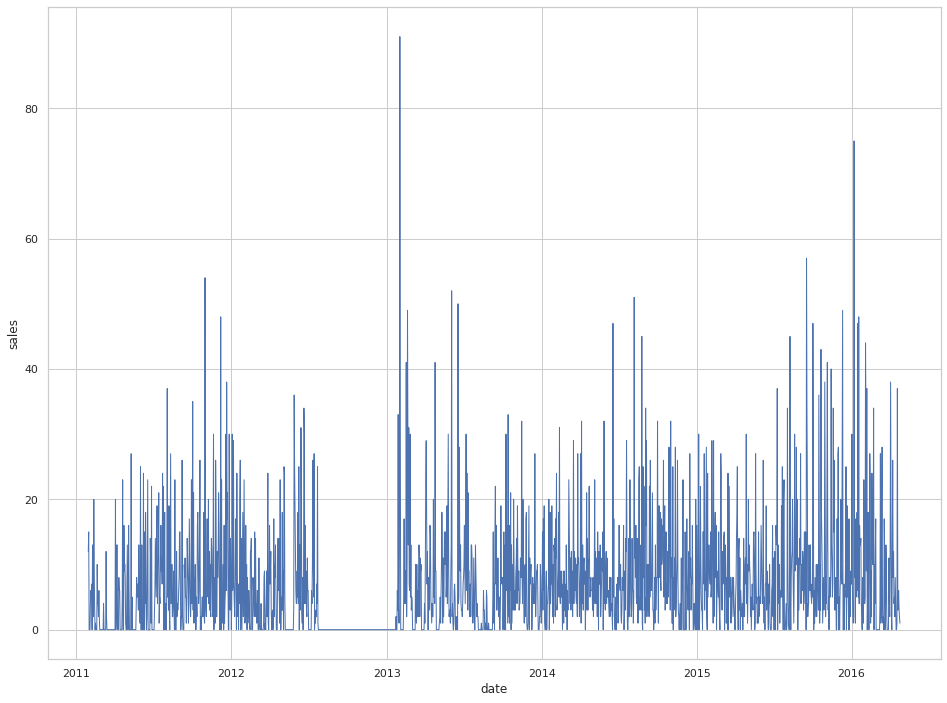

In [17]:
plt.figure(figsize=[16,12])
sns.lineplot(data=tsdf, x='date', y='sales', palette="tab10", linewidth=1)

## 1B: Create Benchmarks

### Moving Average

In [0]:
# Utility Error
class ParameterError(Exception):
  pass

In [0]:
# Calculate root mean squared scaled error
def rmsse(orig_series, pred_series, h=1, intermittent = True):
  '''
  Calculates Root Mean Scaled Squared Error as defined in competitor's guide.

  Parameters
  ----------
  orig_series: A numpy compatible object of the original series.

  pred_series: A numpy compatible object of a model fit.

  h: The forecast horizon assumed to be appended on the tail of orig_series and
  pred_series. A value of 1 assumes no forecast and no averaging occurs.

  intermittent: If the RMSSE should be calculated for areas of series' value 
  below 0.

  Returns
  -------
  The RMSSE
  '''

  s1 = np.array(orig_series)
  s2 = np.array(pred_series)

  if intermittent:
    nz_idx = s1 > 0
    s1 = s1[nz_idx]
    s2 = s2[nz_idx]

  # Squared error
  se = np.sum(np.square(s1 - s2))
  # Scaled diff
  sdiff = ( 1 / (len(s1) - 1) ) * np.sum(np.square(s1[1:] - np.diff(s1))) + 1e-7

  rmsse = np.sqrt( 1/h * (se / sdiff) )

  return rmsse

In [0]:
def moving_average(series, windows, h=0):
  '''
  Calculates rolling mean using provided time windows. If multiple windows are
  given, outputs a list of MA series with their respective window.

  Parameters
  ----------
  series: A Pandas Series object to calculate the MA on.

  windows: An iterable object which lists the number of previous levels to be 
  considered.

  h: A forecast horizon for prediction. h = 0 means no prediction.


  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested moving averages.
    'out_sample_preds': A pandas DataFrame with predictions up to h.
  '''

  rolling_means = []
  preds_list = []

  for w in windows:
    rolling_mean = series.rolling(window=w).mean()
    rolling_mean[:w-1] = series[:w-1]
    rolling_mean.name = f'{series.name}_MA{w}'
    rolling_means.append(rolling_mean)

    if h > 0:
      preds = rolling_mean[-w:]

      for i in range(h):
        # Do not need to calculate rolling mean again for full series, only last
        pred = preds[-w:].rolling(window=w).mean()[-1:]
        preds = preds.append(pred, ignore_index = True)

      # Only keep the predicted entries
      preds = preds.iloc[w:]
      preds = preds.reset_index(drop=True)

    preds_list.append(preds)

  preds_df = pd.DataFrame(preds_list).T
  rolling_means = pd.DataFrame(rolling_means).T
  
  return_dict = {
      'series': series,
      'in_sample_fit': rolling_means,
      'out_sample_preds': preds_df,
  }

  return return_dict

In [243]:
# Test MA
mas = moving_average(ts, [4,3,2], h=20)
mas

{'in_sample_fit':           sales_MA4  sales_MA3  sales_MA2
 0             12.00  12.000000       12.0
 1             15.00  15.000000       13.5
 2              0.00   9.000000        7.5
 3              6.75   5.000000        0.0
 4              3.75   0.000000        0.0
 ...             ...        ...        ...
 45753600      11.25  14.666667        3.5
 45753601      12.50   4.333333        5.0
 45753602       4.00   4.333333        4.5
 45966991       3.75   3.666667        2.5
 45966992       3.00   2.000000        1.5
 
 [1913 rows x 3 columns],
 'out_sample_preds':     sales_MA4  sales_MA3  sales_MA2
 0    5.812500   3.333333   2.000000
 1    4.140625   3.000000   1.750000
 2    4.175781   2.777778   1.875000
 3    4.282227   3.037037   1.812500
 4    4.602783   2.938272   1.843750
 5    4.300354   2.917695   1.828125
 6    4.340286   2.964335   1.835938
 7    4.381413   2.940101   1.832031
 8    4.406209   2.940710   1.833984
 9    4.357065   2.948382   1.833008
 10   4.3712

In [260]:
# Test RMSSE
rmsse(ts, mas['in_sample_fit'].sales_MA4)

22.160350534498455

### Exponential Smoothing

In [0]:
# Utility functions for smoothing params
def check_smoothing_params(params):
  for p in params:
      if (p * 100) - int(p * 100) != 0:
        raise ParameterError("Only 2 significant digits for smoothing parameters are accepted. Received {}".format(a))
      if (p > 0.99) or (p < 0.1):
        raise ParameterError("Smoothing parameters must be between 0 and 1. Received {}".format(a))


In [0]:
def exponential_smoothing(series, alphas, h = 0):
  '''
  Calculates exponential smoothing model on given series and smoothing params.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  alphas: An iterable object of smoothing parameters which currently accepts 
  any value. Values over 2 significant figures are not allowed currently.

  h: Integer. The number of time steps for a forecast horizon

  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested SES models.
    'out_sample_preds': A pandas DataFrame with predictions up to h.
  '''

  check_smoothing_params(alphas)
  
  # Append smoothed series to this list
  ES_ALL = []
  preds_all = []

  # For each alpha listed,
  for a in alphas:
    name = 'ES_a{:0>2d}'.format(int(a * 100))
    ES = pd.Series(series[0])
    ES = ES.append(pd.Series(series[1]))
    # iterate over the series creating another smoothed series
    for idx in range(1, len(series)-1):
      ES = ES.append(pd.Series(a * series.iloc[idx] + (1 - a) * ES.iloc[idx - 1]))
  
    if h > 0:
      ES_preds = []
      ES_preds.append(ES.iloc[-1])
      ES_preds.append(ES.iloc[-2])
      for idx in range(1, h):
        ES_preds.append(pd.Series(a * ES_preds[idx] + (1 - a) * ES_preds[idx - 1]))
      
      ES_preds = pd.Series(ES_preds)
      ES_preds.name = name
      preds_all.append(ES_preds)
##
    # Rename for merging later
    ES.name = name
    ES = ES.reset_index(drop=True)
    ES_ALL.append(ES)

  ES_ALL = pd.DataFrame(ES_ALL).T
  preds_df = pd.DataFrame(preds_all).T

  return_dict = {
      'series': series,
      'in_sample_fit': ES_ALL,
      'out_sample_preds': preds_df,
  }


  return return_dict
  

In [378]:
ses = exponential_smoothing(ts, [0.1, 0.2], 2)
ses['out_sample_preds']

,ES_a10,ES_a20
0,6.16835,4.97622
1,8.67411,8.64314
2,0 6.418922 dtype: float64,0 5.709602 dtype: float64


### Double Exponential Smoothing

In [0]:
def double_exponential_smoothing(series, alphas, betas, h):
  '''
  Calculates double exponential smoothing model on given series and smoothing params.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  alphas: An iterable object of smoothing parameters. Values over 2 significant figures are not allowed.

  beta: An iterable object of secondary smoothing parameters. Values over 2 significant figures are not allowed.

  h: Integer. The number of time steps in the future for prediction.

  Returns
  -------
  A list of double exponential smoothing models with n = alphas.length * betas.length.
  '''

  s = np.array(series)
  check_smoothing_params(alphas)
  check_smoothing_params(betas)
  
  # Append smoothed series to this list
  DBL_ES_ALL = []

  # For each alpha listed,
  for a in alphas:
    # and each beta listed,
    for b in betas:
      DBL_ES = [series.iloc[0]]
      # iterate over the series creating another smoothed series
      for idx in range(1, len(series)):
        if idx == 1:
          level, trend = series.iloc[0], series.iloc[1] - series.iloc[0]
        if idx >= len(series):
          val = series.iloc[-1]
        else:
          val = series.iloc[idx]

        last_level, level = level, a * val + (1 - a) * (level + trend)
        trend = b * (level - last_level) + (1 - b) * trend
        DBL_ES.append(level + trend)

    DBL_ES = pd.Series(DBL_ES)
    # Rename for merging later
    DBL_ES = DBL_ES.rename('DBL_ES_a{:0>2d}_b{:0>2d}'.format(int(a * 100), int(b * 100)))
    DBL_ES_ALL.append(DBL_ES)

  DBL_ES_ALL = pd.DataFrame(DBL_ES_ALL).T

  return_dict = {
      'series': series,
      'in_sample_fit': DBL_ES_ALL,
      'out_sample_preds': [],
  }

  return DBL_ES_ALL

In [65]:
des = double_exponential_smoothing(ts, [0.3], [0.2])
des = des.set_index(ts.index.values)
des

,DBL_ES_a30_b20
0,12.000000
1,18.000000
2,14.520000
3,11.212800
4,8.224992
...,...
45753600,8.011140
45753601,7.504799
45753602,5.980072
45966991,4.373959


In [0]:
tsdf = tsdf.merge(des, left_index=True, right_index=True)

In [70]:
# Melt to get in shape for sns plot
tsdf_melt = tsdf.melt(id_vars='date', value_vars=['sales', 'DBL_ES_a30_b20'])
tsdf_melt

,date,variable,value
0,2011-01-29,sales,12.000000
1,2011-01-30,sales,15.000000
2,2011-01-31,sales,0.000000
3,2011-02-01,sales,0.000000
4,2011-02-02,sales,0.000000
...,...,...,...
3821,2016-04-20,DBL_ES_a30_b20,8.011140
3822,2016-04-21,DBL_ES_a30_b20,7.504799
3823,2016-04-22,DBL_ES_a30_b20,5.980072
3824,2016-04-23,DBL_ES_a30_b20,4.373959


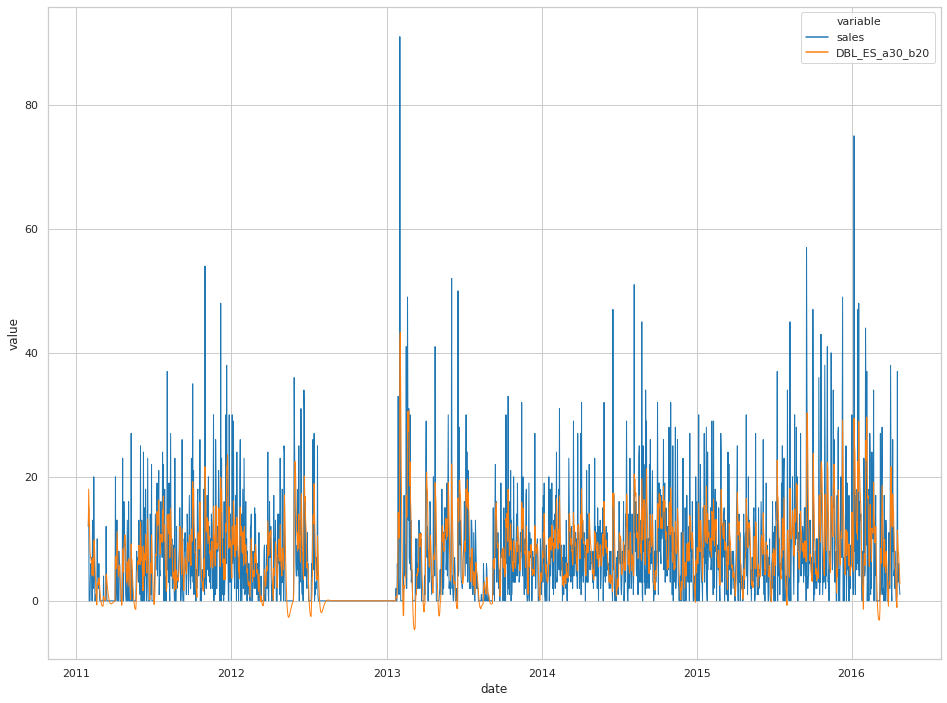

In [76]:
plt.figure(figsize=[16,12])
sns.lineplot(data=tsdf_melt, x='date', y='value', hue='variable', palette="tab10", linewidth=1)

### Croston's Method and Variants

In [0]:
def crostons_method(series, variant = 'original'):
  '''
  Calculates Croston's Method and some of its variants.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.
  variant: The Croston's Method variant. Default's to 'original'. Available options are:
    'original' - original set with exponential smoothing at 0.1.
    'optcro' - exponential smoothing selected from [0.1, 0.3].
    'sba' - Syntetos-Boylan Approximation includes a debias but otherwise same as 'optcro'.
    'tsb' - Teunter-Syntetos-Babai replaces the demand interval, p, with demand probability.

  Returns
  -------
  Pandas Series with the same length as the input.
  '''

  input_series = np.asarray(series)
  series_length = len(input_series)
  v = variant.lower()
  

  # Decompose series into non-zero demand and zero demand
  # Non-zero demand
  nzd = np.where(input_series != 0)[0]
  k = len(nzd)
  z = input_series[nzd]

  # Inter-demand intervals
  p = np.concatenate([[nzd[0]], np.diff(nzd)])

  # TSB variant where demand is non-zero then 1 else 0
  # Trick to transform p to d (demand probability)
  if v == 'tsb':
    p = np.zeros(len(input_series))
    p[np.argwhere(input_series > 1)] = 1

  
  d = np.zeros(len(input_series))
  d[np.argwhere(input_series > 1)] = 1
  
  '''
  # Initialize
  start = z[0]

  z_croston = np.array([None] * k)
  p_croston = np.array([None] * k)

  z_croston[0] = init[0]
  # TODO: Difference between mean or just the first obs?
  p_croston[0] = mean(p)
  '''
  # Find best smoothing parameter for each series
  # Parameter suggestions here are in the M5 Competitors Guide
  if v == 'original':
    alphas = 0.1
  elif (v == 'optcro') | (v == 'sba') | (v == 'tsb'):
    alphas = range(0.1, 0.3, 0.02)
  else:
    alphas = 0.1

  rmsse_z = []
  rmsse_p = []

  
  # Regular linear search. Could add more sophistication here but not necessary for now
  for a in alphas:

    z_fit0 = exponential_smoothing(z, a)
    rmsse_z.append(rmsse(z, z_fit0))

    p_fit0 = exponential_smoothing(p, a)
    rmsse_p.append(rmsse(p, p_fit0))

  a_z = np.argmin(rmsse_z)
  a_p = np.argmin(rmsse_p)

  del z_fit0,p_fit0

  z_fit = exponential_smoothing(z, a_z)
  p_fit = exponential_smoothing(p, a_p)

  # Set the debiasing factor based on version as listed in competitor's guide
  if v == 'sba':
    debias = 1 - (a_p / 2)
  else:
    debias = 1

  if v == 'tsb':
    fit = p_fit * z_fit
  else:
    fit = debias * ( z_fit / p_fit )

  fit = pd.Series(fit)
  fit.rename(f'CRO_{v}')
  return fit
  

The next baseline models will come from open sources due to time and humility.

### ARIMA and Variants

In [0]:
from statsmodels.tsa.arima_model import ARIMA
## Need to add exog
def opt_arima(series, h=0):
  '''
  Optimizes ARIMA variants using RMSSE.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  h: The forecast horizon.

  Returns
  -------
  Dictionary of the best ARIMA parameters according to RMSSE and model fit:
   'arima_pdq': Parameters of ARIMA model.
   'arima_fit': ARIMA model fit.
  
  '''
  ps = [1, 2, 3, 4, 5, 6]
  ds = [1, 2, 3]
  qs = [1, 2, 3, 4, 5, 6]

  costs = []
  model_desc = []
  m = 1

  # Grid search of model parameters
  for p in ps:
    for d in ds:
      for q in qs:
        model = ARIMA(series, order = (p, d, q))
        model_fit = model.fit(disp=-1)
        resid = model_fit.geterrors([p, d, q], )
        resid_mean = np.mean(resid)
        if h > 0:
          cost = rmsse(series, model_fit, h = h)
        else:
          cost = rmsse(series, model_fit)
        costs.append(costs)
        model_desc.append( [p, d, q] )
        
        if m > 1:
          if cost < cost[m-1]:
            best_model = [p, d, q]
            best_model_fit = model_fit
        else:
          best_model = [p, d, q]
          best_model_fit = model_fit
        m+=1
  if h > 0:
    preds = model_fit.predict(best_model, start = len(resid)+1, end = h, typ = 'levels')

  return_dict = {
      'series' : series,
      'arima_pdq' : best_model,
      'arima_fit' : model_fit,
      'in_sample_pred' : 
      'out_sample_pred' : 
  }

  return return_dict